# Visualizing Climbing Data from 8a.nu using SQL and Tableau



### Introduction
Climbing has transformed from an off-the-beaten-path lifestyle, to a competitive sport being featured in the 2021 olympics. Unlike a lot of other popular sports such as basketball and football, data is sparse when it comes to climbing!


### The Data
Luckily, kaggle has a great dataset of users from the world's largest rock climbing logbook, 8a.nu. The dataset was collected on 9/13/2017 and can be found on kaggle https://www.kaggle.com/dcohen21/8anu-climbing-logbook. The data is held in a sqlite database. 

### Jargon Alert!
Climbers (myself included) love jargon. In case you are not familiar with climbing, here are a few terms to lookout for!

1. **Bouldering** - Climbing a smaller rock a.k.a. "boulder" without ropes. Typically short, requiring power.
2. **Route** - Climbing a longer mountain-side "route" using a rope. Typically long, requiring endurance.
3. **Send or Ascent** - Succesfully climbing to the top of a route or boulder.
4. **Grade** - This describes the difficulty of a climb. Grading a route or boulder can be subjective. On top of that, there are separate grading systems for routes and boulders. AND on top of that, there are different US and European grading systems! See https://rockandice.com/how-to-climb/climbing-grades-explained/ for more details on this complex system!

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

## Understanding the sql data schema

In [3]:
#Make a connection
con = sqlite3.connect('database.sqlite')

#Make a cursor instance
c = con.cursor()

How many tables are in the sql database and what are their names?

In [4]:
#Look at all of the tables within the sqlite databes
def table_names():
    query = """
    SELECT NAME 
    FROM SQLITE_MASTER 
    WHERE type= 'table';
    """
    c.execute(query)
    
    tables = []
    for row in c.fetchall():
        tables.append(row[0])
    
    return tables

In [5]:
all_tables = table_names()

for table in all_tables:
    print(table)

user
method
grade
ascent


In [6]:
def col_info():
    #Get table names
    tables = table_names()
    
    #Initialize dataframes for each table
    dfs = {}

    for table in tables:
        #d[table] = pd.DataFrame()
        
        query = f"""
        PRAGMA table_info({table})
        """
        c.execute(query)
        
        Column = []
        Type = []
        Not_Null = []
        Primary_Key = []
        
        for row in c:
            Column.append(row[1])
            Type.append(row[2])
            if row[3]:
                Not_Null.append("YES")
            else:
                Not_Null.append("NO")
            if row[5]:
                Primary_Key.append("YES")
            else:
                Primary_Key.append("")
            
        dfs[table] = pd.DataFrame({"Column" : Column,
                          "Type" : Type,
                          "Not_Null" : Not_Null,
                          "Primary_Key" : Primary_Key})
    return dfs 

In [7]:
column_info_dfs = col_info()

In [8]:
column_info_dfs["user"]

,Column,Type,Not_Null,Primary_Key
0,id,INTEGER,YES,YES
1,first_name,VARCHAR,NO,
2,last_name,VARCHAR,NO,
3,city,VARCHAR,NO,
4,country,VARCHAR,NO,
5,sex,INTEGER,NO,
6,height,INTEGER,NO,
7,weight,INTEGER,NO,
8,started,INTEGER,NO,
9,competitions,VARCHAR,NO,


In [9]:
column_info_dfs["method"]

,Column,Type,Not_Null,Primary_Key
0,id,INTEGER,YES,YES
1,score,INTEGER,NO,
2,shorthand,VARCHAR,NO,
3,name,VARCHAR,NO,


In [10]:
column_info_dfs["grade"]

,Column,Type,Not_Null,Primary_Key
0,id,INTEGER,YES,YES
1,score,INTEGER,NO,
2,fra_routes,VARCHAR,NO,
3,fra_routes_input,BOOLEAN,NO,
4,fra_routes_selector,BOOLEAN,NO,
5,fra_boulders,VARCHAR,NO,
6,fra_boulders_input,BOOLEAN,NO,
7,fra_boulders_selector,BOOLEAN,NO,
8,usa_routes,VARCHAR,NO,
9,usa_routes_input,BOOLEAN,NO,


In [11]:
column_info_dfs["ascent"]

,Column,Type,Not_Null,Primary_Key
0,id,INTEGER,YES,YES
1,user_id,INTEGER,NO,
2,grade_id,INTEGER,NO,
3,notes,VARCHAR,NO,
4,raw_notes,INTEGER,NO,
5,method_id,INTEGER,NO,
6,climb_type,INTEGER,NO,
7,total_score,INTEGER,NO,
8,date,INTEGER,NO,
9,year,INTEGER,NO,


In [12]:
def countRows():
    #Get table names
    tables = table_names()
    
    for table in tables:
        query = f"""
        SELECT COUNT(id)
        FROM {table}
        """
        count = c.execute(query).fetchall()[0][0]
        print(f"{table} table:  {count} rows")
        

In [13]:
countRows()

user table:  62593 rows
method table:  5 rows
grade table:  83 rows
ascent table:  4111877 rows


### Tables Summary

There are 4 tables:

1. **user** - Individual user info such as *sex*, *climbing year start*, *location*, *height*, and *weight*.
<br>

2. **method** - Lookup table to regarding the climb method *likley not needed in this analysis*.
<br>

3. **grade** - Lookup table describing grades. Can be joined to the ascent table for verbose grade details. 
<br>

4. **ascent** - Individual "send" table. Includes the user_id and grade_id which can be joined to the user and grade table respectively.

The largest tables is the **ascent table** with more than 4 million rows. The user table is the second largest around 63,000 rows. 

<br>
<br>

### Questions

With the database sorted out, we can now form questions that can be answered with metrics derived from the tables.

1. **What yearly trends do we see in the popularity of climbing? How do these trends differ among men and women?**


2. **Who is the average climber?**


3. **Are climbers improving over time?**
    - Average grade per year
    - Max grade per year
    - Segment by boulders and routes


In [25]:
def queryToDataframe(query, connection = con):
    """
    Takes a sql query, and a connection.
    Returns a dataframe.
    """
    df = pd.read_sql(query, connection)
    return df

#### 1. *What yearly trends do we see in the popularity of climbing? How do these trends differ among men and women?*

We can answer this question with the user table and querying:
1. Number of climbers that started each year.
2. Segment these users by sex.

In [15]:
year_count_segmented = queryToDataframe("""
WITH t AS
    (
    SELECT COUNT(started) AS total, started AS year
    FROM user
    WHERE year BETWEEN 1960 AND 2017
    GROUP BY(year)
    ),
f AS
    (
    SELECT COUNT(started) AS female, started AS year
    FROM user
    WHERE year BETWEEN 1960 AND 2017
        AND sex = 1
    GROUP BY(year)
    ),
m AS
    (
    SELECT COUNT(started) AS male, started AS year
    FROM user
    WHERE year BETWEEN 1960 AND 2017
        AND sex = 0
    GROUP BY(year)
    )
SELECT t.year, t.total, m.male, IFNULL(f.female, 0) AS female
FROM t
LEFT JOIN f
    ON t.year = f.year
LEFT JOIN m
    ON t.year = m.year
""")

In [16]:
year_count_segmented.tail()

,year,total,male,female
52,2013,1034,829,205
53,2014,747,600,147
54,2015,538,417,121
55,2016,285,228,57
56,2017,58,42,16


In [17]:
def write_csv(df, path, filename):
    """
    Takes a dataframe, path, and filename.
    Returns a written csv.
    Checks if the csv is already written, and if the path is correct.
    """
    file = os.path.join(path, filename)

    if os.path.exists(path):
        if os.path.exists(file):
            print(f"The csv {filename} already exists.")
        else:
            pd.DataFrame.to_csv(df, file)
    else:
        print(f"The path {path} does not exist.")

In [18]:
write_csv(year_count_segmented, "clean_data", "popularity_growth.csv")

The csv popularity_growth.csv already exists.


In [19]:
def multiLinePlot(df, x, time = False, title = "", ylab = "", xlab = ""):
    if time:
        xvar = pd.to_datetime(df[x], format = '%Y').dt.year
        xvar = df[x]
        
    yvars = df.drop(columns = x)
    ycols = yvars.columns.values
    
    for col in ycols:
        plt.plot(xvar, df[col], label = col)
    
    plt.legend()
    
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)

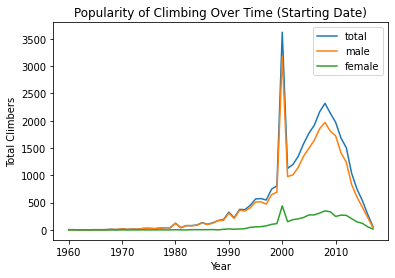

In [20]:
multiLinePlot(df = year_count_segmented, 
              x = "year", 
              time = True, 
              title = "Popularity of Climbing Over Time (Starting Date)",
              ylab = "Total Climbers",
              xlab = "Year")

Climbing popularity starts climbing exponentially (pun intended) from around the year 1990 for men, and around the year 2000 for women.

<br> The growth of female climbers is slow than among male climbers, and has a slight lag.

<br>
There is an unexplained peak in the year 2000 which may be an artifact of the database. Another important note is that the users of 8a.nu are likely outdoor climbers. Given the experience needed to outdoor climb, we likely would not see many registered users who started climbing around when this database was published (2017) since they would be either indoor climbers, or refrain from signing up.

#### 2. *Who is the average climber?*

Several metrics can describe the *average* / *most typical* climber in the 8a.nu dataset including:

1. Ratio of male vs female
2. Average height
3. Average weight
4. Most common occupation
5. Most common location
6. Average grade climbed
7. Max grade climbed

In [21]:
sex_ratio = queryToDataframe("""
SELECT COUNT(*) AS count, 
    CASE WHEN sex = 0 THEN 'male'
         WHEN sex = 1 THEN 'female'
         ELSE 'NA'
    END AS sex
FROM user
GROUP BY sex
ORDER BY count DESC
""")

In [22]:
sex_ratio

,count,sex
0,53898,male
1,8691,female
2,4,NA


In [62]:
# Get average weight and height
# Get most common country and occupation
weight_height_country_job = queryToDataframe("""
WITH c AS 
    (SELECT COUNT(*) AS count, country
     FROM user
     GROUP BY country
     ORDER BY count DESC
     LIMIT 1),
    
    wh AS
    (SELECT AVG(weight) AS avg_weight, 
        AVG(height) AS avg_height
     FROM user),
    
    j AS
    (SELECT COUNT(*) AS count, LOWER(occupation) AS job 
     FROM user
     WHERE job IS NOT NULL
         AND job != ''
     GROUP BY job
     ORDER BY count DESC
     LIMIT 1)
     
SELECT c.country, wh.avg_weight, wh.avg_height, j.job
FROM c, wh, j
""")

In [63]:
weight_height_country_job

,country,avg_weight,avg_height,job
0,USA,33.121899,83.884204,student


In [81]:
queryToDataframe("""
WITH a AS 
    (SELECT CAST(ROUND(AVG(grade_id)) AS int) AS grade_id,
    CASE WHEN climb_type = 0 THEN 'route'
         WHEN climb_type = 1 THEN 'boulder'
         ELSE 'NA'
    END AS climb 
    FROM ascent
    GROUP BY climb),
    g AS
    (SELECT fra_routes, fra_boulders, usa_routes,usa_boulders, id
    FROM grade)

SELECT *
FROM a
LEFT JOIN g
    ON a.grade_id = g.id
""")

# The grade table lacks a value for the US boulder score which translate roughly to V6

,grade_id,climb,fra_routes,fra_boulders,usa_routes,usa_boulders,id
0,47,boulder,6c+/7a,6C+/7A,5.11c,,47
1,47,route,6c+/7a,6C+/7A,5.11c,,47


In [82]:
queryToDataframe("""
SELECT *
FROM grade
ORDER BY id DESC
LIMIT 50
""")

,id,score,fra_routes,fra_routes_input,fra_routes_selector,fra_boulders,fra_boulders_input,fra_boulders_selector,usa_routes,usa_routes_input,usa_routes_selector,usa_boulders,usa_boulders_input,usa_boulders_selector
0,86,1575,9c+/10a,0,0,9C+/10A,0,0,,0,0,,0,0
1,85,1550,9c+,0,0,9C+,0,0,,0,0,,0,0
2,84,1525,9c/+,0,0,9C/+,0,0,,0,0,,0,0
3,83,1500,9c,0,0,9C,0,0,,0,0,,0,0
4,82,1475,9b+/9c,0,0,9B+/9C,0,0,,0,0,,0,0
5,81,1450,9b+,1,1,9B+,0,0,5.15c,1,1,V20,0,0
6,80,1425,9b/+,1,0,9B/+,0,0,5.15b/c,1,0,V19/20,0,0
7,79,1400,9b,1,0,9B,0,0,5.15b,1,0,V19,0,0
8,78,1375,9a+/9b,1,0,9A+/9B,0,0,5.15a/b,1,0,V18/19,0,0
9,77,1350,9a+,1,0,9A+,0,0,5.15a,1,1,V18,0,0


In [71]:
queryToDataframe("""
SELECT id, grade_id, user_id
FROM ascent
LIMIT 5

""")

,id,grade_id,user_id
0,2,36,1
1,3,36,1
2,4,36,1
3,5,36,1
4,6,36,1


In [72]:
queryToDataframe("""
SELECT a.grade_id, a.user_id, g.fra_boulders
FROM ascent AS a
LEFT JOIN grade AS g
    ON a.grade_id = g.id
LIMIT 5
""")

,grade_id,user_id,fra_boulders
0,36,1,6A
1,36,1,6A
2,36,1,6A
3,36,1,6A
4,36,1,6A


In [23]:
countryTop10 = queryToDataframe("""
SELECT COUNT(*) AS count, country
FROM user
GROUP BY country
ORDER BY count DESC
LIMIT 100
""")

In [132]:
countryTop10

,count,country
0,11861,USA
1,6905,ESP
2,3712,DEU
3,3629,SWE
4,3590,ITA
5,3326,FRA
6,3303,POL
7,2660,GBR
8,2062,BRA
9,1928,AUT


In [1]:
weight_height_average = queryToDataframe("""
SELECT AVG(weight) AS avg_weight, 
       AVG(height) AS avg_height
FROM user
""")

NameError: name 'queryToDataframe' is not defined

In [27]:
weight_height_average

,avg_weight,avg_height,max_country
0,33.121899,83.884204,none


In [148]:
weight_average = queryToDataframe("""
SELECT AVG(weight) AS avg_weight, 
       AVG(height) AS avg_height,
       CASE WHEN sex = 0 THEN 'male'
            WHEN sex = 1 THEN 'female'
            ELSE 'NA'
    END AS sex
FROM user
GROUP BY sex
""")

In [149]:
weight_average

,avg_weight,avg_height,sex
0,34.961297,85.152065,male
1,21.729951,76.043263,female
2,0.000000,36.500000,NA


In [150]:
queryToDataframe("""
SELECT COUNT(*) AS count,
       AVG(weight) AS avg_weight, 
       AVG(height) AS avg_height,
       CASE WHEN sex = 0 THEN 'male'
            WHEN sex = 1 THEN 'female'
            ELSE 'NA'
    END AS sex
FROM user
GROUP BY sex
""")

,count,avg_weight,avg_height,sex
0,53898,34.961297,85.152065,male
1,8691,21.729951,76.043263,female
2,4,0.000000,36.500000,NA


In [ ]:
queryToDataframe("""
SELECT COUNT(*) 
FROM ascent
WHERE 
""")

In order to look at the routes people are climbing, we first need to segment the types of climbs people are doing including:

1. Bouldering
2. Routes

In [48]:
# Count how many ascents are boulders vs routes
queryToDataframe("""
SELECT COUNT(*) AS count
FROM ascent
GROUP BY climb_type
""")

,count
0,2875675
1,1236202


In [42]:
queryToDataframe("""
SELECT 
    MAX(a.grade_id), a.climb_type AS bouldering, a.year, 
    g.fra_routes AS grade 
FROM ascent a, grade g
WHERE a.grade_id = g.id
GROUP BY user_id, bouldering, year
LIMIT 100
""")

,MAX(a.grade_id),bouldering,year,grade
0,49,0,1998,7a
1,55,0,1999,7b+
2,57,0,2000,7c
3,62,0,2001,8a
4,53,0,2002,7b
...,...,...,...,...
95,62,1,2003,8a
96,59,1,2004,7c+
97,62,1,2005,8a
98,59,1,2006,7c+


In [158]:
column_info_dfs["grade"]["Column"]

0                        id
1                     score
2                fra_routes
3          fra_routes_input
4       fra_routes_selector
5              fra_boulders
6        fra_boulders_input
7     fra_boulders_selector
8                usa_routes
9          usa_routes_input
10      usa_routes_selector
11             usa_boulders
12       usa_boulders_input
13    usa_boulders_selector
Name: Column, dtype: object

In [43]:
queryToDataframe("""
SELECT first_name, sex
FROM user
ORDER BY RANDOM()
LIMIT 20
""")

,first_name,sex
0,Simeon,0
1,User,0
2,Ivan,0
3,Alfredo Polo,0
4,Mike,0
5,Protax,0
6,Leon,0
7,Natalia,1
8,Ronald,0
9,george,0
